# Social stat

## Cơ sở lý thuyết

**Giới thiệu về dữ liệu**

Dữ liệu từ Điều tra xã hội chung 2016 (GSS16) Sự miêu tả GSS thu thập dữ
liệu về xã hội Mỹ đương đại để theo dõi và giải thích các xu hướng và
hằng số về thái độ, hành vi và thuộc tính. Hàng trăm xu hướng đã được
theo dõi kể từ năm 1972. Ngoài ra, kể từ khi GSS áp dụng các câu hỏi từ
các cuộc khảo sát trước đó, các xu hướng có thể được theo dõi trong tối
đa 70 năm. GSS chứa cốt lõi tiêu chuẩn gồm các câu hỏi về nhân khẩu học,
hành vi và thái độ, cộng với các chủ đề được quan tâm đặc biệt. Trong số
các chủ đề được đề cập là quyền tự do dân sự, tội phạm và bạo lực, lòng
khoan dung giữa các nhóm, đạo đức, ưu tiên chi tiêu quốc gia, sức khỏe
tâm lý, tính di động xã hội, căng thẳng và các sự kiện đau buồn.

Chi tiết Dữ liệu đến từ NORC tại Đại học Chicago. Dữ liệu đã được sửa
đổi để phục vụ tốt hơn cho các mục tiêu giáo dục cơ bản về khoa học dữ
liệu. Chỉ có 9 trong số 935 biến ban đầu được chọn cho tập dữ liệu này.

Đối tượng nghiên cứu

Trong nhiệm vụ này, chúng tôi phân tích dữ liệu từ GSS 2016, sử dụng nó
để ước tính giá trị dân số các thông số quan tâm về người lớn ở Hoa Kỳ.
Định dạng GSS16 chứa 2867 hàng và 9 cột.

Các trường được sử dụng để nghiên cứu

-   harass5: Trả lời câu hỏi \"Trong 5 năm qua, bạn có bị cấp trên hoặc
    đồng nghiệp quấy rối tại nơi làm việc không, ví dụ, bạn có bị bắt
    nạt, lạm dụng thể chất hoặc tâm lý không?\" Các câu trả lời có thể
    là Có, Không và Không áp dụng.

-   emalmin: Số thư điện tử Số phút dành cho email hàng tuần; thêm vào
    số giờ trong emailhrs (ví dụ: emailmin = 30 trong 2,5 giờ trên
    email).

-   emailhr: thư điện tử Số giờ dành cho email hàng tuần.

-   educ: Số năm đi học.

-   polviews: Quan điểm chính trị. Trả lời câu hỏi "Ngày nay chúng ta
    nghe nói nhiều về phe tự do và phe bảo thủ. Tôi sẽ cho bạn thấy một
    thang điểm bảy mà trên đó các quan điểm chính trị mà mọi người có
    thể nắm giữ được sắp xếp từ cực kỳ tự do--điểm 1--đến cực kỳ bảo
    thủ-- điểm 7. Bạn sẽ đặt mình ở đâu trên thang điểm này?" Các câu
    trả lời có thể là Cực kỳ tự do, Tự do, Hơi tự do, Trung bình, Hơi
    bảo thủ, Bảo thủ, Cực kỳ bảo thủ.

-   Advfront: Trả lời cho câu hỏi \"Ngay cả khi nó không mang lại lợi
    ích ngay lập tức, nghiên cứu khoa học nhằm nâng cao tri thức là cần
    thiết và cần được chính phủ liên bang hỗ trợ.\" Các câu trả lời có
    thể là Rất đồng ý, Đồng ý, Không biết, Không đồng ý và Rất không
    đồng ý.

-   snapchat: người trả lời sẽ trả lời câu hỏi có sử dụng Snapchat hay
    không.

-   instagram: người trả lời sẽ trả lời câu hỏi có sử dụng Instagram hay
    không.

-   Wrkstat: Tình trạng công việc.

**Phát biểu bài toán:**

Bài toán được đặt ra để trả lời câu hỏi về mức độ sử dụng email dựa trên
công việc; tần suất sử dụng một số mạng xã hội như Snapchat, Instagram;
số năm đi học; quan điểm về chính trị, nghiên cứu khoa học; và việc có
bị quấy rối, bắt nạt hay không.

**Giới thiệu lý thuyết:**

**Mô hình GLM (Generalized Linear Model)** là một họ các mô hình thống
kê mạnh mẽ và linh hoạt được sử dụng để mô hình hóa mối quan hệ giữa
biến phụ thuộc và các biến độc lập trong các tình huống không phải là
phân phối chuẩn. GLM mở rộng mô hình hồi quy tuyến tính thông thường để
bao gồm các phân phối khác và các hàm liên kết không tuyến tính để xác
định mối quan hệ giữa biến phụ thuộc và biến độc lập.

Mô hình GLM bao gồm ba thành phần chính:

-   Hàm Liên kết (Link function): Đây là hàm xác định mối quan hệ giữa
    giá trị kỳ vọng của biến phụ thuộc và tổng trọng số của biến độc
    lập. Hàm liên kết cần phải là một hàm liên tục, đồng biến và có đạo
    hàm.

-   Phân phối (Distribution): Đây là phân phối xác định biểu diễn phân
    phối của biến phụ thuộc. Các phân phối thường được sử dụng trong GLM
    bao gồm phân phối Poisson (cho mô hình đếm), phân phối Gaussian (cho
    mô hình hồi quy tuyến tính), phân phối Bernoulli (cho mô hình
    logistic), và nhiều phân phối khác.

-   Hàm liên hệ (Link function): Đây là một ánh xạ giữa giá trị kỳ vọng
    của biến phụ thuộc và tổng trọng số của biến độc lập. Ví dụ, trong
    mô hình hồi quy tuyến tính, hàm liên hệ thường là hàm đồng biến
    (identity function) để duy trì mối quan hệ tuyến tính. Trong trường
    hợp của mô hình logistic, hàm liên hệ là hàm logit.

Mô hình GLM có thể được sử dụng cho nhiều loại dữ liệu và mục tiêu khác
nhau, bao gồm:

-   Hồi quy tuyến tính (Linear Regression): Sử dụng khi biến phụ thuộc
    là liên tục và phân phối Gaussian.

-   Hồi quy logistic (Logistic Regression): Sử dụng khi biến phụ thuộc
    là nhị phân (0/1) và phân phối Bernoulli. Thường được sử dụng trong
    dự đoán xác suất của một sự kiện.

-   Hồi quy Poisson (Poisson Regression): Sử dụng khi biến phụ thuộc là
    số lượng đếm và phân phối Poisson. Thường được sử dụng trong việc mô
    hình hóa tần suất của các sự kiện.

-   Hồi quy nhị thức âm (Negative Binomial Regression): Sử dụng khi biến
    phụ thuộc là số lượng đếm và phân phối negative binomial. Thường
    được sử dụng khi dữ liệu có phương sai không ổn định hơn so với phân
    phối Poisson.

**Lý thuyết Bayes Generalized Linear Model (Bayes GLM)** là một phương
pháp thống kê kết hợp lý thuyết Bayes và mô hình tuyến tính tổng quát
(Generalized Linear Model - GLM) để ước tính tham số và dự đoán trong mô
hình tuyến tính mà đầu vào không phải là dữ liệu có phân phối chuẩn.

Để hiểu rõ hơn về Bayes GLM, chúng ta cần nắm vững hai khái niệm chính:
GLM và lý thuyết Bayes.

Generalized Linear Model (GLM):

Mô hình tuyến tính tổng quát (GLM) là một phương pháp cho phép xây dựng
mô hình tuyến tính giữa biến phụ thuộc và một tập các biến độc lập,
nhưng cho phép biến phụ thuộc không phải là một biến phân phối chuẩn.
GLM bao gồm ba thành phần chính: hàm liên kết (link function), phân phối
của biến phụ thuộc và hàm dự đoán.

**Lý thuyết Bayes:**

Lý thuyết Bayes là một lý thuyết trong xác suất thống kê dựa trên Định
lý Bayes, giúp chúng ta cập nhật kiến thức về một sự kiện dựa trên dữ
liệu mới. Lý thuyết Bayes thường sử dụng phân phối xác suất để thể hiện
sự không chắc chắn và cập nhật kiến thức dựa trên dữ liệu.

Khi kết hợp cả hai khái niệm này, Bayes GLM là một phương pháp ước tính
tham số trong mô hình tuyến tính tổng quát bằng cách sử dụng lý thuyết
Bayes. Thay vì sử dụng phương pháp cực đại hóa hàm hợp lý (Maximum
Likelihood Estimation - MLE) như trong GLM truyền thống, Bayes GLM sử
dụng phân phối xác suất a priori để mô tả sự không chắc chắn về các tham
số mô hình. Khi có dữ liệu mới, phân phối a priori này sẽ được cập nhật
thành phân phối hậu nghiệm (posterior distribution) dựa trên lý thuyết
Bayes.

Cách thức thực hiện Bayes GLM thường liên quan đến việc sử dụng phương
pháp MCMC (Markov Chain Monte Carlo) để xấp xỉ phân phối hậu nghiệm.
Điều này có thể phức tạp và đòi hỏi kiến thức sâu về xác suất thống kê
và lập trình.

**Hàm phạt trong các mô hình hồi quy**

Trong các mô hình hồi quy, hàm phạt (regularization) được sử dụng để
kiểm soát overfitting bằng cách thêm một thành phần phạt vào hàm mất
mát. Hàm phạt giúp giảm thiểu các trọng số của mô hình, từ đó làm giảm
sự phức tạp của mô hình và cân bằng giữa việc đánh đổi giữa sự khớp tốt
với dữ liệu huấn luyện và khả năng tổng quát hóa cho dữ liệu mới. Hai
hàm phạt phổ biến trong các mô hình hồi quy là Ridge và Lasso

Ridge Regression (L2 Regularization): Trong Ridge Regression, một thành
phần phạt được thêm vào hàm mất mát là tổng bình phương của các trọng số
(hệ số) của mô hình. Biểu thức của hàm mất mát trong Ridge Regression
là:

$$J(\theta) = Mất\ mát\ ban\ đầu*\ \alpha*\left\| \theta \right\|^{2}$$

Trong đó:

$J(\theta)$: Hàm mất mát

$\alpha$: Tham số điều chỉnh mức độ phạt

$\theta$: Vector trọng số của mô hình hồi quy

$\left\| \theta \right\|^{2}$: Chuẩn L2 của vector trọng số

**Lasso Regression (L1 Regularization)**: Lasso cũng thêm một thành phần
phạt vào hàm mất mát, nhưng ở đây là tổng trị tuyệt đối của các trọng số
của mô hình

$$J(\theta) = Mất\ mát\ ban\ đầu*\ \alpha*\left\| \theta \right\|_{1}$$

Trong đó:

$J(\theta)$: Hàm mất mát

$\alpha$: Tham số điều chỉnh mức độ phạt

$\theta$: Vector trọng số của mô hình hồi quy

$\left\| \theta \right\|_{1}$: Chuẩn L1 của vector trọng số

**Các metrics để đánh giá mô hình GLM**

**Mean Squared Error (MSE)**: Đây là một trong những metric phổ biến
nhất trong mô hình hồi quy. Nó tính toán trung bình của bình phương sai
giữa giá trị dự đoán và giá trị thực tế

Công thức:
$MSE = \ \frac{1}{n}*\sum_{}^{}{{(y}_{i} - \ {\widehat{y}}_{i})}^{2}$

Trong đó:

$n$: Số mẫu của dữ liệu

$y_{i}$: Giá trị thực tế thứ i

$\widehat{y}$: Giá trị dự đoán của mô hình

Đặc điểm của MSE:

-   Giá trị MSE càng nhỏ, mô hình càng tốt vì nó cho biết các dự đoán dự
    đoán gần với giá trị thực tế.

-   MSE có thể bị ảnh hưởng bởi các giá trị ngoại lai (outliers) vì
    chúng có thể gây ra sai số bình phương lớn.

-   MSE không có đơn vị cụ thể vì nó được tính bằng bình phương của đơn
    vị gốc (ví dụ, nếu dữ liệu đơn vị là đô la, thì MSE có đơn vị \"đô
    la bình phương\").

MSE thường được sử dụng cùng với các metric khác để đánh giá và so sánh
mô hình hồi quy.

**Root Mean Squared Error (RMSE)**: Đây là căn bậc hai của MSE và thường
được sử dụng để đo lường sai số trung bình theo đơn vị gốc

Công thức: $RMSE = \ \sqrt{MSE}$

**Mean Absolute Error (MAE)**: MAE tính trung bình giá trị tuyệt đối của
sai số giữa giá trị dự đoán và giá trị thực tế

Công thức:
$MAE = \ \frac{1}{n}*\ \sum_{}^{}\left| {(y}_{i} - \ {\widehat{y}}_{i} \right|$

**Coefficient of Determination (R²):** R² đo lường mức độ biến thiên của
biến phụ thuộc mà mô hình có thể giải thích. Giá trị R² nằm trong khoảng
\[0, 1\], và giá trị càng gần 1 thì mô hình càng tốt:

Công thức:
$R^{2} = 1 - \ \left( \frac{\sum_{}^{}{{(y}_{i} - \ {\widehat{y}}_{i})}^{2}}{\sum_{}^{}{{(y}_{i} - \ \overline{y})}^{2}} \right)$

Trong đó:

$n$: Số mẫu của dữ liệu

$y_{i}$: Giá trị thực tế thứ i

${\widehat{y}}_{i}$: Giá trị dự đoán của mô hình

$\overline{y}$: Giá trị trung bình của mô hình

**Random Forest** là một thuật toán học máy dựa trên việc xây dựng nhiều
cây quyết định (Decision Trees) độc lập và kết hợp kết quả từ các cây
này để đưa ra dự đoán cuối cùng. Nó giúp cải thiện hiệu suất dự đoán và
ổn định mô hình bằng cách giảm thiểu overfitting và tăng tính tổng quát
hóa. Dưới đây là chi tiết về thuật toán Random Forest:

-   Tạo dữ liệu mẫu (Bootstrapping): Để xây dựng mỗi cây quyết định
    trong Random Forest, chúng ta sẽ tạo ra một tập dữ liệu mẫu từ tập
    dữ liệu huấn luyện bằng cách lấy ngẫu nhiên và có thay thế các mẫu.
    Quá trình này được gọi là bootstrapping.

-   Xây dựng cây quyết định: Với mỗi tập dữ liệu mẫu, ta sẽ xây dựng một
    cây quyết định độc lập bằng cách phân chia dữ liệu theo các thuộc
    tính và giá trị để tối ưu hóa một hàm mục tiêu, thường là tối thiểu
    hóa sai số hoặc tối ưu hóa Gini index (trong trường hợp cây phân
    loại). Quá trình này tiếp tục cho đến khi một điều kiện dừng được
    đáp ứng, chẳng hạn như độ sâu tối đa của cây.

-   Kết hợp dự đoán từ các cây: Khi đã xây dựng các cây quyết định,
    chúng ta có thể sử dụng chúng để đưa ra dự đoán cho các mẫu dữ liệu
    mới. Dự đoán từ mỗi cây đóng vai trò như một phiếu bầu cho một lớp
    (trong trường hợp phân loại) hoặc một giá trị (trong trường hợp hồi
    quy).

-   Kết hợp kết quả từ các cây: Để đưa ra dự đoán cuối cùng, chúng ta
    kết hợp kết quả từ tất cả các cây trong Random Forest. Trong trường
    hợp phân loại, kết quả cuối cùng thường là lớp có số phiếu bầu nhiều
    nhất từ các cây. Trong trường hợp hồi quy, kết quả cuối cùng thường
    là trung bình hoặc trung vị của các dự đoán từ các cây.

Một trong những lợi ích quan trọng của Random Forest là khả năng kiểm
soát overfitting. Bằng cách sử dụng nhiều cây quyết định độc lập, thuật
toán giảm khả năng mô hình bị overfitting vào dữ liệu huấn luyện. Random
Forest có thể được áp dụng cho cả các vấn đề phân loại và hồi quy. Nó
cũng có thể xử lý cả dữ liệu dạng số và dữ liệu dạng danh mục. Thuật
toán Random Forest đã được chứng minh là một công cụ mạnh mẽ trong học
máy và có thể được sử dụng trong nhiều ứng dụng khác nhau như phân loại
hình ảnh, dự đoán giá cổ phiếu, dự đoán bệnh tật, và nhiều lĩnh vực
khác.


Import các thư viện cần thiết

In [120]:
import os
import random
import copy
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels as stm
import torch 
import torch.nn as nn 
import torch.optim as optim
import tqdm

## Thống kê mô tả dữ liệu
<!-- Thống kê mô tả dữ liệu -->

## Tiền xử lý dữ liệu
<!-- Phát hiện outlier -->

In [121]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(0)


Random seed set as 0


Đọc dữ liệu

In [122]:
df = pyreadr.read_r('./data/gss16.rda')
gss16_data = df['gss16']
print(gss16_data.info())
print(gss16_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867 entries, 0 to 2866
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   harass5   1469 non-null   object 
 1   emailmin  1649 non-null   float64
 2   emailhr   1649 non-null   float64
 3   educ      2858 non-null   float64
 4   polviews  2756 non-null   object 
 5   advfront  1385 non-null   object 
 6   snapchat  1372 non-null   object 
 7   instagrm  1372 non-null   object 
 8   wrkstat   2864 non-null   object 
dtypes: float64(3), object(6)
memory usage: 201.7+ KB
None
  harass5  emailmin  emailhr  educ          polviews        advfront snapchat   
0     NaN       0.0     12.0  16.0          Moderate  Strongly agree      NaN  \
1     NaN      30.0      0.0  12.0           Liberal        Disagree       No   
2      No       NaN      NaN  16.0      Conservative             NaN       No   
3     NaN      10.0      0.0  12.0          Moderate        Disagree      NaN   
4

In [123]:
gss16_data.dropna(subset=['emailmin', 'emailhr'], inplace=True)
gss16_data['educ'].fillna(gss16_data['educ'].mean(), inplace = True)

col_num = ['emailmin', 'emailhr', 'educ']
col_cat = ['harass5', 'polviews', 'advfront', 'snapchat', 'instagrm', 'wrkstat']

df_cat = gss16_data[gss16_data.columns.intersection(col_cat)]
df_num = gss16_data[gss16_data.columns.intersection(col_num)]
df_cat_fill = df_cat.fillna('unknown')

print(f'cat na: {df_cat.isna().sum()}')
print(f'cat fill na: {df_cat_fill.isna().sum()}')

print(df_cat.info())
print(df_num.info())

cat na: harass5     1218
polviews      55
advfront     433
snapchat     969
instagrm     969
wrkstat        1
dtype: int64
cat fill na: harass5     0
polviews    0
advfront    0
snapchat    0
instagrm    0
wrkstat     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1649 entries, 0 to 2865
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   harass5   431 non-null    object
 1   polviews  1594 non-null   object
 2   advfront  1216 non-null   object
 3   snapchat  680 non-null    object
 4   instagrm  680 non-null    object
 5   wrkstat   1648 non-null   object
dtypes: object(6)
memory usage: 90.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1649 entries, 0 to 2865
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   emailmin  1649 non-null   float64
 1   emailhr   1649 non-null   float64
 2   educ      1649 non-null   float64
dtypes: float64(3)
m

In [124]:
df_num['email_time'] = df_num['emailhr'] * 60 + df_num['emailmin']

max_email_time = df_num['email_time'].max()
min_email_time = df_num['email_time'].min()
df_num['email_time_center'] = (df_num['email_time'] - min_email_time) / (max_email_time - min_email_time)

/tmp/ipykernel_65744/711746736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['email_time'] = df_num['emailhr'] * 60 + df_num['emailmin']
/tmp/ipykernel_65744/711746736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['email_time_center'] = (df_num['email_time'] - min_email_time) / (max_email_time - min_email_time)


In [125]:
max_educ = df_num['educ'].max()
min_educ = df_num['educ'].min()
df_num['educ_center'] = (df_num['educ'] - min_educ) / (max_educ - min_educ)

/tmp/ipykernel_65744/3923756970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['educ_center'] = (df_num['educ'] - min_educ) / (max_educ - min_educ)


Ghi các tập dữ liệu đã tiền xử lý ra file. Trong đó X, X_fill và y lần lượt là tập đầu vào không coi NaN là một thuộc tính, tập đầu vào coi NaN là thuộc tính ("unlnown"), tập đầu ra

In [126]:
df_cat_dum = pd.get_dummies(df_cat, dtype=int)
df_cat_fill_dum = pd.get_dummies(df_cat_fill, dtype=int)

df_num.to_csv('./data/preprocessing/gss16_number_columns', index=False)
df_cat_dum.to_csv('./data/preprocessing/gss16_dummies_column', index=False)
df_cat_fill_dum.to_csv('./data/preprocessing/gss16_dummies_column_fillna', index=False)

X = pd.concat([df_num['educ_center'], df_cat_dum], axis=1)
X_fill = pd.concat([df_num['educ_center'], df_cat_fill_dum], axis=1)
y = df_num['email_time_center']

X.to_csv('./data/preprocessing/X.csv', index=False)
X_fill.to_csv('./data/preprocessing/X_fill.csv', index=False)
y.to_csv('./data/preprocessing/y.csv', index=False)

Chia tập train, test với tỉ lệ 80/20, cố định `random_state = 42`

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X_fill, y, test_size=0.2, random_state=0)

## Các mô hình tuyến tính

### Mô hình GLM 

### Mô hình GAM

### Mô hình GLM với penalty

### Mô hình GLM với Bayes

### Mô hình Random forest

### Mô hình Deep Learning 
Phần này sử dụng một mạng neural network đơn giản để fit mô hình. 

In [128]:
torch.cuda.is_available()

True

Định nghĩa mô hình và thuật toán tối ưu. 
Mạng gồm 2 hidden layers.
Loss function sử dụng là hàm Mean Square Error.
Thuật toán tối ưu là thuật toán Adam với learning rate 0.0001

In [129]:
model = nn.Sequential(
  nn.Linear(34, 64),
  nn.ReLU(),
  nn.Linear(64, 32),
  nn.Sigmoid(),
  nn.Linear(32, 1)
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Đưa dữ liệu vào vRAM của GPU

In [130]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)

Các tham số cơ bản

In [131]:
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
early_stopping_epoches = 10

Huấn luyện mô hình

In [132]:
# training loop
early = 0
for epoch in range(n_epochs):
    print(f'process epoch: {epoch}')
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    
    print(f'complete epoch {epoch} with mse {mse}')
    if mse > best_mse:
        early += 1
        if early > early_stopping_epoches:
            print(f'early stopping')
            break
    
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

process epoch: 0
complete epoch 0 with mse 0.010031425394117832
process epoch: 1
complete epoch 1 with mse 0.009739500470459461
process epoch: 2
complete epoch 2 with mse 0.00951495859771967
process epoch: 3
complete epoch 3 with mse 0.009347761049866676
process epoch: 4
complete epoch 4 with mse 0.009239904582500458
process epoch: 5
complete epoch 5 with mse 0.009174576960504055
process epoch: 6
complete epoch 6 with mse 0.009139987640082836
process epoch: 7
complete epoch 7 with mse 0.009124045260250568
process epoch: 8
complete epoch 8 with mse 0.009116451255977154
process epoch: 9
complete epoch 9 with mse 0.009111744351685047
process epoch: 10
complete epoch 10 with mse 0.009109902195632458
process epoch: 11
complete epoch 11 with mse 0.009108904749155045
process epoch: 12
complete epoch 12 with mse 0.009107954800128937
process epoch: 13
complete epoch 13 with mse 0.00910917017608881
process epoch: 14
complete epoch 14 with mse 0.00910990685224533
process epoch: 15
complete epoch 

Vẽ đồ thị loss function theo epoch

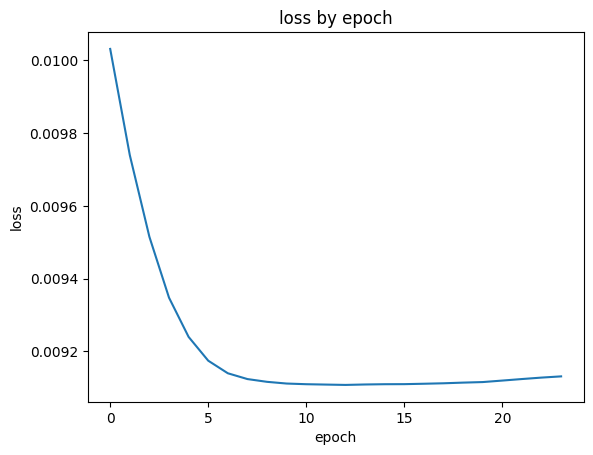

In [133]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss by epoch')
plt.plot(history)
plt.show()

In ra các độ đo

In [134]:
y_pred = model(X_test)
y_pred_df = pd.DataFrame(y_pred.detach().numpy())
y_test_df = pd.DataFrame(y_test.detach().numpy())

mse = mean_squared_error(y_test_df, y_pred_df)
r2 = r2_score(y_test_df, y_pred_df)

print(f'MSE: {mse}')
print(f'RMSE: {np.sqrt(mse)}')
print(f'R2: {r2}')

MSE: 0.009107955731451511
RMSE: 0.09543561190366745
R2: 0.08015310318547786
